In [1]:
import os
import pickle
from urllib import request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api import types
from sklearn import compose, dummy, ensemble, impute, metrics, model_selection, pipeline, preprocessing
from sklearn.externals import joblib
import xgboost as xgb

In [2]:
%matplotlib notebook

In the process you will learn a bit about the [scikit-learn](https://scikit-learn.org/stable/index.html) API as well as how to use [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html). XGBoost is an optimized distributed gradient boosting library that implements machine learning algorithms under the [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) framework.

# 1. Look at the "Big Picture"

## What are we trying to accomplish? 

Objective is to follow a path laid out by the NERSC [autoscan](http://portal.nersc.gov/project/dessn/autoscan/) project (HT to engineers from [Dessa](https://medium.com/@dessa_/space-2-vec-fd900f5566) for making me aware of the autoscan project and for motivating the code in this notebook) and build a model capable of detecting [Type Ia Supernovae (SNe Ia)](https://en.wikipedia.org/wiki/Type_Ia_supernova) from image data produced by the [Dark Energy Survey Supernova (DES-SN)](https://www.darkenergysurvey.org/) program so that we can reduce the amount of human time required to manually examine image data for presence of super novae.

## How will the solution be used?

Our model will be one piece of a much larger data analysis pipeline discussed in [Goldstein et al (2015)](https://arxiv.org/pdf/1504.02936.pdf) 

<img src=./assets/goldstein-et-al-2015-figure-2.png>

## What are the current solutions?

Typically scientists _manually_ identify interesting moving objects in the sky from imaging survey data by visually inspecting images for relevant signatures. However, recent advances in telescopes, detectors, and HPCs have led to a dramatic rise in the data production rates of imaging surveys and any manual steps in data analysis pipelines are now significant bottlenecks.


### Question:

Is this a problem a **supervised** or **unsupervised** learning problem? Are we faced with a **classification** task or a **regression** task, or something else? Should we use **batch** learning or **online** learning techniques?

### Answers:

Since we are working with labeled data we are dealing with a supervised learning problem; since we wish to classify whether an image contains a Type Ia supernova we are faced with a classification task. At present there is no real-time, streaming aspect to the data so we can use batch learning techniques (however one could imagine that online learning might be useful in the future given that the raw data is collected nightly).

## How should we measure performance?

Serveral [performance metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) typically considered for supervised classification problems: [precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve), [recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score), false-positive rate (FPR), missed detection rate (MDR) (**N.B.** MDR = 1 - recall = TPR). The [receiver-operating characteristic (ROC) curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve) visually trades-off the FPR and TPR. We can compute the [area under the ROC curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) and use it as our overall measure of classifier performance.

Remember that our "business objective" is to minimize the human time spent manually examining images for the presence of super novae. So whilst area under the ROC curve is a good metric to optimize when choosing the best classifier, we will also measure the performance of the classifier in terms of the number of hours of human time saved. We want to save human time but not at the expense of throwing away too many images containing super novae: not more than 1% of images containing super novae can be lost! Formally this corresponds to choosing a decision boundary of our tuned classifier such that that classifier has a 99% recall rate.

# 2. Get the Data

## Downloading the data

All of the data can be downloaded from the NERSC [autoscan](http://portal.nersc.gov/project/dessn/autoscan/) project website. In this notebook we will work with the engineered features from the [Goldstein et al (2015)](https://arxiv.org/pdf/1504.02936.pdf) paper.

In [3]:
raw_data_path = "../data/raw"
if not os.path.isfile(f"{raw_data_path}/autoscan_features.2.csv"):
    os.makedirs(raw_data_path)
    url = "http://portal.nersc.gov/project/dessn/autoscan/autoscan_features.2.csv"
    _ = request.urlretrieve(url, f"{raw_data_path}/autoscan_features.2.csv")

In [4]:
!head ../data/raw/autoscan_features.2.csv

# autoscan training data
# use the id column to cross-match rows with thumbnails
# object_type gives the class of the row
# object_type = 0: artifact
# object_type = 1: non-artifact
# remaining 38 columns defined in section 3 and table 2 of companion paper 
ID,OBJECT_TYPE,AMP,A_IMAGE,A_REF,BAND,B_IMAGE,B_REF,CCDID,COLMEDS,DIFFSUMRN,ELLIPTICITY,FLAGS,FLUX_RATIO,GAUSS,GFLUX,L1,LACOSMIC,MAG,MAGDIFF,MAGLIM,MAG_FROM_LIMIT,MAG_REF,MAG_REF_ERR,MASKFRAC,MIN_DISTANCE_TO_EDGE_IN_NEW,N2SIG3,N2SIG3SHIFT,N2SIG5,N2SIG5SHIFT,N3SIG3,N3SIG3SHIFT,N3SIG5,N3SIG5SHIFT,NN_DIST_RENORM,NUMNEGRN,SCALE,SNR,SPREADERR_MODEL,SPREAD_MODEL
10742010,0,0.8083234429359436,1.5080000162124634,2.65006947517395,i,0.949999988079071,1.8995014429092407,10,0.11207699775695801,25.857545852661133,0.37002652883529663,0,0.2590300440788269,226.4202880859375,1.0089635848999023,103.80699920654297,1.736109972000122,23.031299591064453,-0.4524995982646942,0,1.6222000122070312,22.578800201416016,0.11959999799728394,0.0,559.7000122070312,

## Loading the data

Once downloading is complete we can load the raw CSV file into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [5]:
_dtype = {"MAGLIM": "bool",
          "BAND": "category",
          "CCDID": "category",
          "FLAGS": "category",
          "N2SIG3": types.CategoricalDtype(categories=range(23), ordered=True),
          "N2SIG3SHIFT": types.CategoricalDtype(categories=range(-25, 26), ordered=True),
          "N2SIG5": types.CategoricalDtype(categories=range(45), ordered=True),
          "N2SIG5SHIFT": types.CategoricalDtype(categories=range(-49, 50), ordered=True),
          "N3SIG3": types.CategoricalDtype(categories=range(23), ordered=True),
          "N3SIG3SHIFT": types.CategoricalDtype(categories=range(-25, 26), ordered=True),
          "N3SIG5": types.CategoricalDtype(categories=range(43), ordered=True),
          "N3SIG5SHIFT": types.CategoricalDtype(categories=range(-49, 50), ordered=True)}

autoscan_features = pd.read_csv(f"{raw_data_path}/autoscan_features.2.csv",
                                header=0,
                                comment='#',
                                index_col="ID",
                                dtype=_dtype)

In [6]:
autoscan_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 898963 entries, 10742010 to 7800868
Data columns (total 39 columns):
OBJECT_TYPE                    898963 non-null int64
AMP                            898963 non-null float64
A_IMAGE                        898963 non-null float64
A_REF                          843149 non-null float64
BAND                           898963 non-null category
B_IMAGE                        898963 non-null float64
B_REF                          843149 non-null float64
CCDID                          898963 non-null category
COLMEDS                        898963 non-null float64
DIFFSUMRN                      898963 non-null float64
ELLIPTICITY                    898963 non-null float64
FLAGS                          898963 non-null category
FLUX_RATIO                     898963 non-null float64
GAUSS                          898963 non-null float64
GFLUX                          898963 non-null float64
L1                             898963 non-null float64


In [7]:
autoscan_features.head()

,OBJECT_TYPE,AMP,A_IMAGE,A_REF,BAND,B_IMAGE,B_REF,CCDID,COLMEDS,DIFFSUMRN,...,N3SIG3,N3SIG3SHIFT,N3SIG5,N3SIG5SHIFT,NN_DIST_RENORM,NUMNEGRN,SCALE,SNR,SPREADERR_MODEL,SPREAD_MODEL
ID,,,,,,,,,,,,,,,,,,,,,
10742010,0,0.808323,1.508,2.650069,i,0.950,1.899501,10,0.112077,25.857546,...,0,-8,0,-9,0.674934,22,2.024122,7.722346,0.004629,-0.003718
8828139,0,0.975141,1.430,NaN,i,1.319,NaN,10,0.072256,38.029022,...,0,5,0,5,NaN,21,1.379283,25.582918,0.002420,-0.000578
8229889,0,0.877440,0.505,NaN,z,0.494,NaN,57,0.106124,14.436153,...,0,1,0,1,NaN,20,0.950069,3.914192,0.008863,-0.020044
11033218,0,0.681179,0.762,3.008957,i,0.449,2.855881,1,0.139071,27.118200,...,0,-14,2,-27,1.240574,18,1.749488,5.068382,0.008041,0.000246
8341858,0,0.645906,1.205,1.352224,i,0.982,1.063333,30,0.123302,25.487835,...,0,4,0,4,2.970234,16,1.930613,7.372579,0.005606,0.001771


## Creating a testing set

In [8]:
_prng = np.random.RandomState(42)
training_features, testing_features = model_selection.train_test_split(autoscan_features,
                                                                       test_size=0.2,
                                                                       random_state=_prng,
                                                                       stratify=autoscan_features.OBJECT_TYPE)

Since the autoscan features data set is not too large we will go ahead and save both the training and more importantly the testing features data sets to disk.

In [9]:
interim_data_path = "../data/interim"
if not os.path.isdir(interim_data_path):
    os.makedirs(interim_data_path)
    
training_features.to_csv(f"{interim_data_path}/training_features.csv")
testing_features.to_csv(f"{interim_data_path}/testing_features.csv")

# 4. Prepare the data for ML algorithms

## Data cleaning

Most ML algorithms can not work with missing values. Do we have any missing values in our training data?

In [123]:
(training_features.isna()
                  .sum()
                  .sort_values(ascending=False))

A_REF                          44743
NN_DIST_RENORM                 44743
MAG_REF                        44743
MAG_REF_ERR                    44743
B_REF                          44743
SPREAD_MODEL                       0
ELLIPTICITY                        0
L1                                 0
GFLUX                              0
GAUSS                              0
FLUX_RATIO                         0
FLAGS                              0
COLMEDS                            0
DIFFSUMRN                          0
MAG                                0
CCDID                              0
B_IMAGE                            0
BAND                               0
A_IMAGE                            0
AMP                                0
LACOSMIC                           0
MAGLIM                             0
MAGDIFF                            0
N3SIG3                             0
SNR                                0
SCALE                              0
NUMNEGRN                           0
N

In [126]:
# semi-major axis of nearest source in galaxy coadd catalog (if exists within 5", else imputed)
(training_features.A_REF
                  .describe())

count    674427.000000
mean          3.821103
std           7.372656
min           0.692358
25%           2.221944
50%           2.794353
75%           4.087810
max         815.111328
Name: A_REF, dtype: float64

In [127]:
# distance from detection to nearest source in galaxy coadd catalog (if exists within 5", else imputed)
(training_features.NN_DIST_RENORM
                  .describe())

count    674427.000000
mean          0.921008
std           0.852281
min           0.001016
25%           0.418017
50%           0.696747
75%           1.057845
max           4.999983
Name: NN_DIST_RENORM, dtype: float64

In [128]:
# magnitude of nearest source in galaxy coadd catalog (if exists within 5", else imputed)
(training_features.MAG_REF
                  .describe())

count    674427.000000
mean         20.988036
std           4.296380
min          13.204200
25%          19.297300
50%          20.699600
75%          22.316200
max          99.000000
Name: MAG_REF, dtype: float64

In [129]:
# uncertainty of MAG_REF (if exists, else imputed)
(training_features.MAG_REF_ERR
                  .describe())

count    674427.000000
mean          0.036684
std           0.091378
min           0.000100
25%           0.002200
50%           0.006100
75%           0.029600
max           1.000000
Name: MAG_REF_ERR, dtype: float64

In [131]:
# semi-minor axis of nearest source in galaxy coadd catalog (if exists within 5", else imputed)
(training_features.B_REF
                  .describe())

count    674427.000000
mean          2.729035
std           1.777635
min           0.288675
25%           1.940005
50%           2.381958
75%           3.024719
max          72.474854
Name: B_REF, dtype: float64

Couple of approaches we could take:

1. Drop all rows containing any missing values.
2. Impute the missing values.

Table 2 of the paper provides descriptions of each the features and suggests that missing values were imputed using the mean value.

In [139]:
impute.SimpleImputer?

## Handling Categorical Features

We also have several categorical variables (both ordered and unordered) which need to be properly encoded.

In [10]:
categorical_columns = ["MAGLIM",
                       "BAND",
                       "CCDID",
                       "FLAGS"]

In [138]:
# for unordered categorical variables
preprocessing.OneHotEncoder?

In [11]:
ordinal_columns = ["N2SIG3",
                   "N2SIG3SHIFT",
                   "N2SIG5",
                   "N2SIG5SHIFT",
                   "N3SIG3",
                   "N3SIG3SHIFT",
                   "N3SIG5",
                   "N3SIG5SHIFT",
                   "NUMNEGRN"]

In [141]:
# for ordered categorical variables
preprocessing.OrdinalEncoder?

## Feature Scaling

Many of the features have values that differ by several orders of magnitude. For some ML algorithms, such as random forests, re-scaling of features will make little (or no) difference but for other ML algorithms re-scaling is critical to achieving good performance. 

In [12]:
columns_to_scale = ["AMP",
                    "A_REF",
                    "A_IMAGE",
                    "B_REF",
                    "DIFFSUMRN",
                    "ELLIPTICITY",
                    "FLUX_RATIO",
                    "GAUSS",
                    "GFLUX",
                    "L1",
                    "LACOSMIC",
                    "MAG",
                    "MAGDIFF",
                    "MAG_FROM_LIMIT",
                    "MAG_REF",
                    "MAG_REF_ERR",
                    "MASKFRAC",
                    "MIN_DISTANCE_TO_EDGE_IN_NEW",
                    "NN_DIST_RENORM",
                    "SCALE",
                    "SNR",
                    "SPREADERR_MODEL",
                    "SPREAD_MODEL"]

## Transformation Pipelines

In [13]:
# get some details on your CPU
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                72
On-line CPU(s) list:   0-71
Thread(s) per core:    2
Core(s) per socket:    18
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 85
Model name:            Intel(R) Xeon(R) Gold 6150 CPU @ 2.70GHz
Stepping:              4
CPU MHz:               1700.000
CPU max MHz:           2701.0000
CPU min MHz:           1200.0000
BogoMIPS:              5400.00
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              1024K
L3 cache:              25344K
NUMA node0 CPU(s):     0-17,36-53
NUMA node1 CPU(s):     18-35,54-71
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl 

In [14]:
# get somee details on your GPU
!nvidia-smi

Tue Feb 12 16:03:40 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:AF:00.0  On |                  N/A |
| 25%   43C    P5    23W / 250W |    699MiB / 11178MiB |      6%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [41]:
NUMBER_CORES = 36
NUMBER_CPUS = 2 * NUMBER_CORES

In [16]:
_rescaling_pipeline = pipeline.make_pipeline(
    impute.SimpleImputer(),
    preprocessing.StandardScaler()
)

column_transformer = compose.make_column_transformer(
    (_rescaling_pipeline, columns_to_scale),
    (preprocessing.OneHotEncoder(), categorical_columns),
    (preprocessing.OrdinalEncoder(), ordinal_columns),
    remainder="passthrough",
    n_jobs=4
)

In [86]:
transformed_training_features = column_transformer.fit_transform(training_features.drop("OBJECT_TYPE", axis=1))

In [87]:
training_target = (training_features.get("OBJECT_TYPE")
                                    .values)

In [88]:
final_data_path = "../data/final"
if not os.path.isdir(final_data_path):
    os.makedirs(final_data_path)
_ = joblib.dump(transformed_training_features, f"{final_data_path}/transformed-training-features.pkl")
_ = joblib.dump(training_target, f"{final_data_path}/training-target.pkl")

# 5. Select and Train a model

In [20]:
# seed used for all models that require source of randomness
SEED = 42

# number of folds to use for CV
NUMBER_CV_FOLDS = 3

# number of jobs to use for CV
NUMBER_CV_JOBS = NUMBER_CV_FOLDS

# use area under ROC for scoring CV
SCORING = metrics.make_scorer(metrics.roc_auc_score, needs_proba=True)

## Benchmark "dummy" classifier

In [21]:
benchmark_clf = dummy.DummyClassifier(strategy="most_frequent")

In [22]:
benchmark_clf.fit(transformed_training_features, training_target)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [23]:
benchmark_auc_scores = model_selection.cross_val_score(benchmark_clf,
                                                       transformed_training_features,
                                                       training_target,
                                                       cv=NUMBER_CV_FOLDS,
                                                       scoring=SCORING,
                                                       n_jobs=NUMBER_CV_JOBS)

In [24]:
benchmark_auc_scores.mean()

0.5

## AdaBoost classifier

In [25]:
_prng = np.random.RandomState(SEED)
ada_boost_clf = ensemble.AdaBoostClassifier(random_state=_prng)

In [26]:
ada_boost_clf.fit(Z, y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50,
          random_state=<mtrand.RandomState object at 0x7f6f6f6ad090>)

In [27]:
models_path = "../models/"
if not os.path.isdir(final_data_path):
    os.makedirs(final_data_path)
_ = joblib.dump(ada_boost_clf, f"{models_path}/ada-boost-classifier.pkl")

### Scoring AdaBoost

In [28]:
ada_boost_auc_scores = model_selection.cross_val_score(ada_boost_clf,
                                                       transformed_training_features,
                                                       training_target,
                                                       cv=NUMBER_CV_FOLDS,
                                                       scoring=SCORING,
                                                       n_jobs=NUMBER_CV_JOBS)

In [29]:
ada_boost_auc_scores.mean()

0.9835888575516057

## Random Forest classifier

In [30]:
_prng = np.random.RandomState(SEED)
random_forest_clf = ensemble.RandomForestClassifier(n_estimators=100,
                                                    n_jobs=NUMBER_CPUS // NUMBER_CV_JOBS,
                                                    random_state=_prng)

In [31]:
random_forest_clf.fit(Z, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=24,
            oob_score=False,
            random_state=<mtrand.RandomState object at 0x7f6f6f3ada68>,
            verbose=0, warm_start=False)

In [32]:
_ = joblib.dump(random_forest_clf, "../models/random-forest-classifier.pkl")

### Scoring the Random Forest classifier

In [33]:
random_forest_auc_scores = model_selection.cross_val_score(random_forest_clf,
                                                           transformed_training_features,
                                                           training_target,
                                                           cv=NUMBER_CV_FOLDS,
                                                           scoring=SCORING,
                                                           n_jobs=NUMBER_CV_JOBS)

In [34]:
random_forest_auc_scores.mean()

0.9927092709216261

## XGBoost classifier

### Fitting XGBoost classifier using CPU

In [42]:
xgb_cpu_params = {'subsample': 0.8,
                  'colsample_bytree': 0.8,
                  'tree_method': 'hist',
                  'random_state': SEED,
                  'n_jobs': NUMBER_CORES,
                 }

xgb_cpu_clf = xgb.XGBClassifier(**xgb_cpu_params)

In [43]:
%timeit xgb_cpu_clf.fit(transformed_training_features, training_target)

[16:28:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[16:28:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[16:28:50] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[16:28:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[16:29:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[16:29:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[16:29:23] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[16:29:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
8.15 s ± 498 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
xgb_cpu_clf.fit(transformed_training_features, training_target)

[16:33:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=36, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8, tree_method='hist')

In [47]:
_ = joblib.dump(xgb_cpu_clf, "../models/xgboost-cpu-classifier.pkl")

### Fitting XGBoost classifier using GPU

In [56]:
xgb_gpu_params = {'subsample': 0.8,
                  'colsample_bytree': 0.8,
                  'tree_method': 'gpu_hist',
                  'predictor': 'gpu_predictor',
                  'random_state': SEED,
                 }

xgb_gpu_clf = xgb.XGBClassifier(**xgb_gpu_params)

In [55]:
%timeit xgb_gpu_clf.fit(transformed_training_features, training_target)

5.18 s ± 290 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
xgb_gpu_clf.fit(transformed_training_features, training_target)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       predictor='gpu_predictor', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8, tree_method='gpu_hist')

In [49]:
_ = joblib.dump(xgb_gpu_clf, "../models/xgboost-gpu-classifier.pkl")

### Scoring the XGBoost classifier

In [89]:
xgb_cpu_params = {'subsample': 0.8,
                  'colsample_bytree': 0.8,
                  'tree_method': 'hist',
                  'random_state': SEED,
                  'n_jobs': NUMBER_CORES // NUMBER_CV_JOBS,
                 }

xgb_gpu_clf = xgb.XGBClassifier(**xgb_gpu_params)

xgd_cpu_auc_scores = model_selection.cross_val_score(xgb_cpu_clf,
                                                     transformed_training_features,
                                                     training_target,
                                                     cv=NUMBER_CV_FOLDS,
                                                     scoring=SCORING,
                                                     n_jobs=NUMBER_CV_JOBS)

In [90]:
xgd_cpu_auc_scores.mean()

0.9892704301266098

In [57]:
xgd_gpu_auc_scores = model_selection.cross_val_score(xgb_gpu_clf,
                                                     transformed_training_features,
                                                     training_target,
                                                     cv=NUMBER_CV_FOLDS,
                                                     scoring=SCORING,
                                                     n_jobs=NUMBER_CV_JOBS)

In [59]:
xgd_gpu_auc_scores.mean()

0.9892350113775157

# 6. Fine-Tuning a model

Lot's of hyper parameters to tune and no optimal way to tune hyper parameters! How to proceed? Tuning a model ultimately involves a lot of _tinkering_. To avoid over-fitting your model to your training data you should either set aside a validation data set specifically to use when comparing the performance of various combinations of hyper-parameters according to your performance metric, or you should use some form of cross validation.

In general, you should not expect significant gains in model performance to come from tuning hyper-parameters. Significant gains in model performance are more likely to come from using a better model (i.e., convolutional neural networks (CNNs)), finding more data, improved feature engineering, etc.

That said, it is important to convert changes in model performance to changes in the relevant business metric. Sometimes seemingly small gains in model performance are still substantial from a business perspective.
To demonstrate tuning model hyper-parameters, I will use a subset of the grid of hyper-parameters explored in the paper. 

Finally, some notes on balancing resources between fitting a classifier and spawning grid search CV jobs. 

* Increasing the number of concurrent grid search jobs should yield roughly linear scaling
* Increasing the number of threads allocated to fitting the Random Forest classifier will yield sub-linear scaling.

Optimal allocation of threads between fitting the classifier and spawning CV jobs depends on the classifier. With `ensemble.RandomForest` classifier I have not seen any improvement from hyper-threading. 

In [71]:
NUMBER_GRID_SEARCH_JOBS = 9

In [72]:
_prng = np.random.RandomState(SEED)
random_forest_clf = ensemble.RandomForestClassifier(n_estimators=100,
                                                    n_jobs=NUMBER_CORES // NUMBER_GRID_SEARCH_JOBS,
                                                    random_state=_prng)

_hyper_parameter_grid = {"n_estimators": [10, 100],
                         "criterion": ["gini", "entropy"],   
                         "min_samples_split": [2, 3, 4],
                         "max_depth": [5, 30, None]}

random_forest_grid_search = model_selection.GridSearchCV(random_forest_clf,
                                                         param_grid=_hyper_parameter_grid,
                                                         scoring=SCORING,
                                                         iid=True,
                                                         cv=NUMBER_CV_FOLDS,
                                                         n_jobs=NUMBER_GRID_SEARCH_JOBS,
                                                         return_train_score=True,
                                                         verbose=10)

In [73]:
random_forest_grid_search.fit(transformed_training_features, training_target)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   7 tasks      | elapsed:   17.0s
[Parallel(n_jobs=9)]: Done  14 tasks      | elapsed:   46.8s
[Parallel(n_jobs=9)]: Done  23 tasks      | elapsed:  1.1min
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:  2.6min
[Parallel(n_jobs=9)]: Done  43 tasks      | elapsed:  3.3min
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:  4.7min
[Parallel(n_jobs=9)]: Done  67 tasks      | elapsed:  5.4min
[Parallel(n_jobs=9)]: Done  80 tasks      | elapsed:  6.0min
[Parallel(n_jobs=9)]: Done 102 out of 108 | elapsed:  9.1min remaining:   32.1s
[Parallel(n_jobs=9)]: Done 108 out of 108 | elapsed:  9.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False,
            random_state=<mtrand.RandomState object at 0x7f6ef4b68990>,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=9,
       param_grid={'n_estimators': [10, 100], 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 3, 4], 'max_depth': [5, 30, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(roc_auc_score, needs_proba=True), verbose=10)

In [91]:
# only slightly higher than score achieved with default params! :(
random_forest_grid_search.best_score_

0.992949361011106

In [65]:
_hyper_parameter_grid = {"max_depth": [3, 6, 9],
                         "n_estimators": [50, 100, 200],
                         "min_child_weight": [1, 2, 4],   
                         }

xgb_gpu_grid_search = model_selection.GridSearchCV(xgb_gpu_clf,
                                                   param_grid=_hyper_parameter_grid,
                                                   scoring=SCORING,
                                                   iid=True,
                                                   cv=NUMBER_CV_FOLDS,
                                                   n_jobs=NUMBER_GRID_SEARCH_JOBS,
                                                   return_train_score=True,
                                                   verbose=10)

In [66]:
xgb_gpu_grid_search.fit(transformed_training_features, training_target)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   7 tasks      | elapsed:   39.2s
[Parallel(n_jobs=9)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=9)]: Done  23 tasks      | elapsed:  1.5min
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:  2.3min
[Parallel(n_jobs=9)]: Done  43 tasks      | elapsed:  3.5min
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:  4.5min
[Parallel(n_jobs=9)]: Done  73 out of  81 | elapsed:  8.0min remaining:   52.5s
[Parallel(n_jobs=9)]: Done  81 out of  81 | elapsed:  8.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       predictor='gpu_predictor', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8, tree_method='gpu_hist'),
       fit_params=None, iid=True, n_jobs=9,
       param_grid={'max_depth': [3, 6, 9], 'n_estimators': [50, 100, 200], 'min_child_weight': [1, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(roc_auc_score, needs_proba=True), verbose=10)

## Evaluate model performance on the training data

In [93]:
predicted_object_type = model_selection.cross_val_predict(random_forest_grid_search.best_estimator_,
                                                          transformed_training_features,
                                                          training_target,
                                                          cv=NUMBER_CV_FOLDS,
                                                          n_jobs=NUMBER_CV_JOBS)

In [94]:
# row is actual object type; column is predicted object type
metrics.confusion_matrix(predicted_object_type, training_target)

array([[347466,   9412],
       [ 15807, 346485]])

In [95]:
# precision is true-positives / (true-positives + false-positives)
metrics.precision_score(predicted_object_type, training_target)

0.9735541462838967

In [96]:
# recall is true-positives / (true_positives + false-negatives)
metrics.recall_score(predicted_object_type, training_target)

0.9563694478486966

In [97]:
# f1-score is harmonic mean of precision and recall scores (favors classifiers with similar precision and recall)
metrics.f1_score(predicted_object_type, training_target)

0.9648852878559822

In [98]:
predicted_probas = model_selection.cross_val_predict(random_forest_grid_search.best_estimator_,
                                                     transformed_training_features,
                                                     training_target,
                                                     cv=NUMBER_CV_FOLDS,
                                                     method="predict_proba",
                                                     n_jobs=NUMBER_CV_JOBS)

In [99]:
precisions, recalls, thresholds = metrics.precision_recall_curve(training_target, predicted_probas[:, 1])

<IPython.core.display.Javascript object>


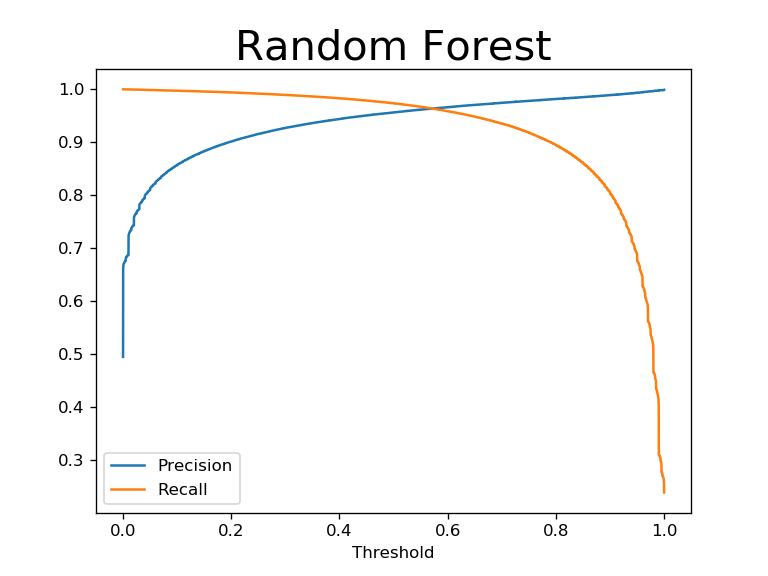

In [100]:
_, ax = plt.subplots(1,1)
ax.plot(thresholds, precisions[:-1], label="Precision")
ax.plot(thresholds, recalls[:-1], label="Recall")
ax.set_xlabel("Threshold")
ax.set_title("Random Forest", fontsize=25)
ax.legend()

In [104]:
_required_threshold = np.max(thresholds[recalls[:-1] > 0.99])
number_images_to_check = np.sum(predicted_probas[:, 1] >= _required_threshold)
number_images_to_check

381181

In [103]:
# cut total human effort in half!
total_training_images, _ = transformed_training_features.shape 
number_images_to_check / total_training_images

0.5300290612789744

## Evaluate model performance on the testing data set

In [67]:
transformed_testing_features = column_transformer.transform(testing_features.drop("OBJECT_TYPE", axis=1))
testing_target = (testing_features.get("OBJECT_TYPE")
                                  .values)

In [69]:
final_data_path = "../data/final"
if not os.path.isdir(final_data_path):
    os.makedirs(final_data_path)
_ = joblib.dump(transformed_testing_features, f"{final_data_path}/transformed-testing-features.pkl")
_ = joblib.dump(testing_target, f"{final_data_path}/testing-target.pkl")

In [74]:
random_forest_auc_scores = model_selection.cross_val_score(random_forest_grid_search.best_estimator_,
                                                           transformed_testing_features,
                                                           testing_target,
                                                           cv=NUMBER_CV_FOLDS,
                                                           scoring=SCORING,
                                                           n_jobs=NUMBER_CV_JOBS)

In [75]:
random_forest_auc_scores.mean()

0.9915172572846179

In [76]:
xgb_gpu_auc_scores = model_selection.cross_val_score(xgb_gpu_grid_search.best_estimator_,
                                                     transformed_testing_features,
                                                     testing_target,
                                                     cv=NUMBER_CV_FOLDS,
                                                     scoring=SCORING,
                                                     n_jobs=NUMBER_CV_JOBS)

In [77]:
xgb_gpu_auc_scores.mean()

0.9941167532043473

Comparing the performance of the tuned Random Forest classifier and the tuned XGBoost classifier as measured by the area under the ROC curve on the testing data set allows us to select the best model. In this case the XGBoost looks like the best model but there isn't too much of a difference between the average scores of the two models.

In [78]:
predicted_object_type = model_selection.cross_val_predict(xgb_gpu_grid_search.best_estimator_,
                                                          transformed_testing_features,
                                                          testing_target,
                                                          cv=NUMBER_CV_FOLDS,
                                                          n_jobs=NUMBER_CV_JOBS)

In [79]:
# row is actual object type; column is predicted object type
metrics.confusion_matrix(predicted_object_type, testing_target)

array([[87391,  2323],
       [ 3428, 86651]])

In [80]:
predicted_probas = model_selection.cross_val_predict(xgb_gpu_grid_search.best_estimator_,
                                                     transformed_testing_features,
                                                     testing_target,
                                                     cv=NUMBER_CV_FOLDS,
                                                     method="predict_proba",
                                                     n_jobs=NUMBER_CV_JOBS)

precisions, recalls, thresholds = metrics.precision_recall_curve(testing_target, predicted_probas[:, 1])

<IPython.core.display.Javascript object>


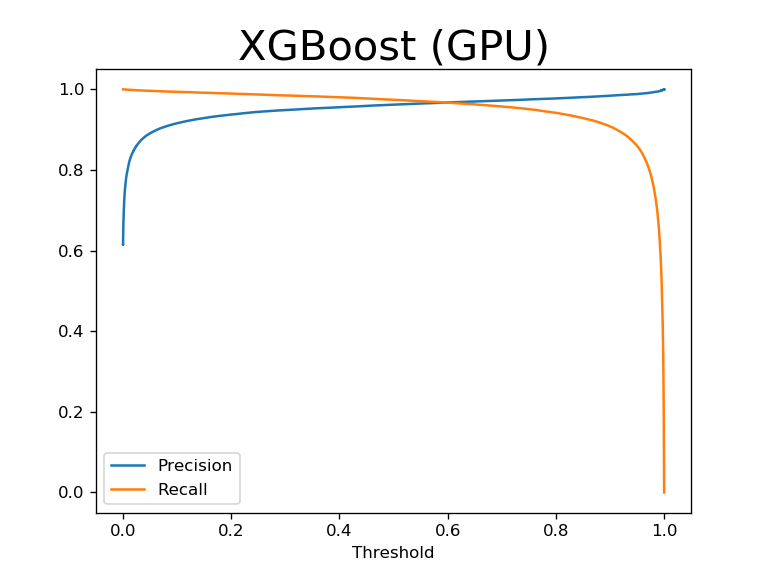

In [81]:
_, ax = plt.subplots(1,1)
ax.plot(thresholds, precisions[:-1], label="Precision")
ax.plot(thresholds, recalls[:-1], label="Recall")
ax.set_xlabel("Threshold")
ax.set_title("XGBoost (GPU)", fontsize=25)
ax.legend()

How much time does the Random Forest model potentially save scientists?

In [82]:
_required_threshold = np.max(thresholds[recalls[:-1] > 0.99])
number_images_to_check = np.sum(predicted_probas[:, 1] >= _required_threshold)
number_images_to_check

94209

In [83]:
# cut total human effort in half!
total_testing_images, _ = transformed_testing_features.shape 
number_images_to_check / total_testing_images

0.5239859171380421

Suppose that it takes a human one second to manually process an image. This means that it would take a human about 2 full days to process the 180,000 images in the testing data set. Using the Random Forest classifier training above one could cut the number of images in need of manual processing in half! Note also that the number of false positives is low and implies that only 38 minutes of wasted human effort. 